In [1]:
from IPython import display
from ipyevents import Event
from rich.jupyter import display
%matplotlib widget
from ipywidgets import IntSlider, Output, HTML
import ipywidgets as widgets
from ipywidgets import Image
from IPython.display import display
from ipyevents import Event

import pandas as pd
from scipy.stats import lognorm, rv_continuous, pareto
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math

# Read data

## Heritage

In [5]:
# Read inheritance data
df_herit = pd.read_csv("data/heritage-cae.csv", comment="#")
df_herit = df_herit.rename(columns={key: key.split("[")[0] for key in df.columns})
df_herit.quant = df_herit.quant / 100
df_herit = df_herit.set_index("quant")
df_herit

,heritage
quant,
0.100,0
0.200,15000
0.300,47000
0.400,65000
0.500,65000
0.600,65000
0.700,84000
0.800,164000
0.900,288000


# Taux imposition

# Read taux effectif
df_taux = pd.read_csv("data/taux_effectifs.csv", comment="#")
df_taux = df_taux.rename(columns={key: key.split("[")[0] for key in df.columns})
df_taux.quant = df_taux.quant / 100
df_taux = df_taux.set_index("quant")
df_taux

# Join the two
df = df_herit.join(df_taux)
df

# Compute 

## Volumes

In [18]:
# Compute volumes for each quantile
quantiles = np.insert(df.index.values, 0, [0])
volumes = df.heritage.values * (quantiles[1:] - quantiles[0:-1])

df["volumes"] = volumes

print("Average volume", df.volumes.sum())

df
#print("%g" % (volume.sum() * nb_menages))

Average volume 190502.11199999903


,heritage,actuel,assiette1-bareme1,assiette2-bareme2,assiette1-bareme3,assiette2-bareme4,volumes
quant,,,,,,,
0.100,0,0.0,0.0,0.0,0.0,0.0,0.000
0.200,15000,0.0,0.0,0.0,0.0,0.0,1500.000
0.300,47000,0.0,0.0,0.0,0.0,0.0,4700.000
0.400,65000,0.0,0.0,0.0,0.0,0.0,6500.000
0.500,65000,0.0,0.0,0.0,0.0,0.0,6500.000
0.600,65000,0.0,0.0,0.0,0.0,0.0,6500.000
0.700,84000,0.0,1.0,1.0,0.0,0.0,8400.000
0.800,164000,1.0,1.0,2.0,0.0,0.0,16400.000
0.900,288000,2.0,2.0,5.0,1.0,1.0,28800.000


# Approximate with parametrized distributions

In [4]:
# Generate random sample of this CDF
rnd = np.random.random(100000) * 0.95
samples = np.interp(rnd, df.quantiles, df.wealth)
samples

array([ 68604.72511995, 244195.88387625,    712.38506355, ...,
       113081.52129868, 459871.69594682,  82040.04885265])

In [5]:
# Fit the parametric distribution
distrib_f = pareto
distrib_args = distrib_f.fit(samples)

{'arg1': IntSlider(value=6, max=12, min=3), 'arg2': IntSlider(value=-1224618, max=-612309, min=-2449237), 'arg3': IntSlider(value=1224619, max=2449238, min=612309)}


interactive(children=(IntSlider(value=6, description='arg1', max=12, min=3), IntSlider(value=-1224618, descrip…

<function __main__.plot_distrib(arg1, arg2, arg3)>

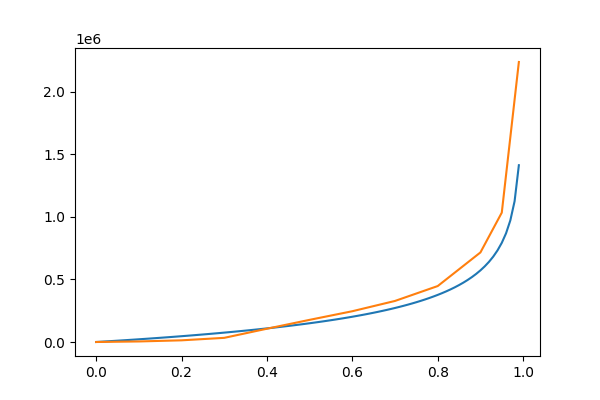

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

def plot_distrib(arg1, arg2, arg3) :
    distrib = distrib_f(arg1, arg2, arg3)

    # Generate samples for this distrib
    x = np.arange(0, 1, 0.01)
    y = distrib.ppf(x)
    
    ax.clear()
    ax.plot(x, y)
    ax.plot(df.quantiles, df.wealth)
    
interact_args = {
    "arg%d" % (i+1): IntSlider(
        min=arg/2 if arg > 0 else arg*2,
        max=arg*2 if arg > 0 else arg/2,
        value=arg) for i, arg in enumerate(distrib_args)}

print(interact_args)

widgets.interact(
    plot_distrib,
    **interact_args)

# Inégalités plot

In [33]:
ineg=pd.read_csv("data/inegalites.csv")
ineg

,heritage,part
0,8000,38.7
1,30000,27.1
2,100000,21.2
3,200000,13.0


In [34]:
fig = go.Figure(data=[go.Bar(
    x=ineg.part,
    y=ineg.heritage)
])

fig.update_xaxes(title_text='Part de la population (%)')
fig.update_yaxes(title_text='Héritage (€)')
fig.show()

# Get visual data

In [55]:
with open("img/taux_effectif.png", "rb") as img :
    im_widget = Image(value=img.read())

event_widget = Event(source=im_widget, watched_events=['click'])

out = HTML('')



def handle_event(event):
    
    px = int(event["offsetX"])
    py = int(event["offsetY"])
    
    x = int((px - 102) / (956-102) * 13 + 1.5) * 10
    y = int((560 - py) / (560 - 58) * 40)
    
    if x == 100:
        x = 95
    elif x == 110 :
        x = 99
    elif x == 120 :
        x = 99.5
    elif x == 130 :
        x = 99.9
    elif x == 140 :
        x = 100
      
    csv =  ("%.2f,%.2f" % (x, y)) + "<br>"
    
    out.value = out.value + csv
    
event_widget.on_dom_event(handle_event)
display(im_widget, out)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xef\x00\x00\x02\xce\x08\x06\x00\x00\x00\xd8\xfd"…

HTML(value='')